In [1]:
import numpy as np
from pathlib import Path
import unicodedata
from transformers import AutoTokenizer
from collections import Counter
import matplotlib.pyplot as plt
from jaxtyping import Int, Float


<font size="6">Get Text Data

In [2]:
def get_gutenberg_book(
	id: int|None = 84,
	data_temp: Path|str = "../data/gutenberg_data",
	remove_gutenberg_meta: bool = True,
) -> str:
	
	data_temp = Path(data_temp)
	data_temp.mkdir(parents=True, exist_ok=True)
	
	url: str = f"https://www.gutenberg.org/cache/epub/{id}/pg{id}.txt"
	data_path: Path = Path(data_temp) / f"{id}.txt"
	data: str
	# read from cache if it exists
	if data_path.exists():
		with open(data_path, 'r', encoding='utf-8') as file:
			data = file.read()
	else:
		# download if it doesn't exist
		response = requests.get(url)
		response.raise_for_status()  # Ensure that the download was successful
		data = response.text

		# save to cache
		with open(data_path, 'w', encoding='utf-8') as file:
			file.write(data)

	# remove header/footer
	if remove_gutenberg_meta:
		data = '***'.join(data.split('***')[2:])
		data = '***'.join(data.split('***')[:-1])
	
	return data

def get_many_books(
		ids: list[int],
		data_temp: Path|str = "../decoding-gpt/data/gutenberg_data",
	) -> list[str]:
	
	data: list[str] = []
	for id in ids:
		print(f"Getting book {id}...")
		item: str = get_gutenberg_book(id, data_temp)
		print(f"\t{len(item)} characters read")
		data.append(item)
	
	return data

In [3]:
DATA_RAW: list[str] = get_many_books([84,82,996])

print(f"{sum(len(x) for x in DATA_RAW) = }")

Getting book 84...
	419446 characters read
Getting book 82...
	1103816 characters read
Getting book 996...
	2299372 characters read
sum(len(x) for x in DATA_RAW) = 3822634


In [4]:
def process_text(
	text: str,
	allowed_punctuation: str = "-.,;:!?()\"" + "".join(str(x) for x in range(10)),
	punctuation_convert: dict[str,str] = {'—': '-'},
) -> str:
	
	# replace some special characters which unicode won't normalize properly
	for char, replacement in punctuation_convert.items():
		text = text.replace(char, replacement)

	# if a line has ".jpg" in it, remove that line (this is specific to Don Quixote)
	text = '\n'.join(
		line 
		for line in text.split('\n')
		if '.jpg' not in line
	)

	# Normalize the string to decompose Unicode characters
	text = unicodedata.normalize('NFKD', text)

	# Encode to ASCII bytes, then decode back to string, ignoring errors
	text = text.encode('ascii', 'ignore').decode('ascii')

	# remove newlines and tabs
	text = text.replace('\n', ' ').replace('\t', ' ')


	# put spaces around allowed punctuation
	for char in allowed_punctuation:
		text = text.replace(char, f' {char} ')


	# remove leading and trailing spaces
	text = text.strip()

	# remove multiple spaces
	while '  ' in text:
		text = text.replace('  ', ' ')


	# remove all characters except (alphanumeric, allowed_punctuation, ' ')
	text = ''.join(
		(
			char 
			if (
				char.isalnum() 
				or char in allowed_punctuation 
				or char == ' '
			)
			else ' '
		)
		for char in text 
	)

	# convert to lowercase
	text = text.lower()

	text = text.strip()

	return text


In [5]:
DATA: str = " ".join(process_text(x) for x in DATA_RAW)

print(DATA[:1000])


frankenstein ; or , the modern prometheus by mary wollstonecraft ( godwin ) shelley contents letter 1 letter 2 letter 3 letter 4 chapter 1 chapter 2 chapter 3 chapter 4 chapter 5 chapter 6 chapter 7 chapter 8 chapter 9 chapter 1 0 chapter 1 1 chapter 1 2 chapter 1 3 chapter 1 4 chapter 1 5 chapter 1 6 chapter 1 7 chapter 1 8 chapter 1 9 chapter 2 0 chapter 2 1 chapter 2 2 chapter 2 3 chapter 2 4 letter 1  to mrs . saville , england .   st . petersburgh , dec . 1 1 th , 1 7 - . you will rejoice to hear that no disaster has accompanied the commencement of an enterprise which you have regarded with such evil forebodings . i arrived here yesterday , and my first task is to assure my dear sister of my welfare and increasing confidence in the success of my undertaking . i am already far north of london , and as i walk in the streets of petersburgh , i feel a cold northern breeze play upon my cheeks , which braces my nerves and fills me with delight . do you understand this feeling ? this bre

<font size="6">Makov Chain Trainning using BERT-Base, GPT-2 and Word Based Tokenizer

<font size="5">BERT-Base

In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def train_markov_chain_bert(data_encoded: np.ndarray, vocab_size: int) -> np.ndarray:
    chain = np.zeros((vocab_size, vocab_size), dtype=np.float32)
    
    # Count transitions
    for i in range(len(data_encoded) - 1):
        chain[data_encoded[i], data_encoded[i + 1]] += 1

    # Normalize the matrix
    for row in range(vocab_size):
        row_sum = chain[row].sum()
        if row_sum > 0:
            # Normalize the row only if there are transitions
            chain[row] = chain[row] / row_sum

    return chain


def tokenize_with_bert(text: str, chunk_size: int = 512) -> np.ndarray:
    # Tokenize the text in chunks and return a flattened array of token IDs
    tokens = []
    for i in range(0, len(text), chunk_size):
        chunk = text[i:i+chunk_size]
        tokens.extend(tokenizer.encode(chunk, add_special_tokens=False))
    return np.array(tokens, dtype=np.int32)


my_text = DATA
data_encoded = tokenize_with_bert(my_text, chunk_size=512)
vocab_size_bert = tokenizer.vocab_size

# Train the Markov chain
CHAIN_BERT = train_markov_chain_bert(data_encoded, vocab_size_bert)

<font size="4">Just to check if the chain working or not 

In [7]:
def chain_generate_bert(
    context: str,
    chain: np.ndarray,
    max_new_tokens: int,
    return_encoded: bool = False,
) -> str:
    # Tokenize the context with BERT tokenizer
    context_encoded = tokenize_with_bert(context)
    context_list = context_encoded.tolist()

    # Generate new tokens using the Markov chain
    for _ in range(max_new_tokens):
        # Use the last token in the context to predict the next token
        last_token_id = context_list[-1]
        # Make sure to handle cases where the Markov chain row sums to zero
        if chain[last_token_id].sum() == 0:
            break  # End the generation if no next token can be predicted
        next_token_id = np.random.choice(
            chain.shape[1],
            p=chain[last_token_id]
        )
        context_list.append(next_token_id)
    
    if return_encoded:
        return context_list
    else:
        # Decode the token IDs back to text using BERT tokenizer
        return tokenizer.decode(context_list, clean_up_tokenization_spaces=True)
    


generated_text_bert = chain_generate_bert(
    context="You are",
    chain=CHAIN_BERT,
    max_new_tokens=50,
)
print(generated_text_bert)


2024-02-27 18:52:08.385413: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


you are born into it you are about there, with profuse inquiries. i can be, he passed away in the effectediable to fetching wrong to the writer was partly braided rocinante, but though clean exhausted with the perse with maiden


<font size="5">GPT-2

In [8]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")

def train_markov_chain_gpt2(data_encoded: np.ndarray, vocab_size: int) -> np.ndarray:
    chain = np.zeros((vocab_size, vocab_size), dtype=np.float32)
    
    # Count transitions
    for i in range(len(data_encoded) - 1):
        chain[data_encoded[i], data_encoded[i + 1]] += 1

    # Normalize the matrix
    for row in range(vocab_size):
        row_sum = chain[row].sum()
        if row_sum > 0:
            # Normalize the row only if there are transitions
            chain[row] = chain[row] / row_sum

    return chain


def tokenize_with_gpt2(text: str, chunk_size: int = 1024) -> np.ndarray:
    # Tokenize the text in chunks and return a flattened array of token IDs
    tokens = []
    for i in range(0, len(text), chunk_size):
        chunk = text[i:i+chunk_size]
        tokens.extend(tokenizer.encode(chunk))
    return np.array(tokens, dtype=np.int32)


my_text = DATA
data_encoded = tokenize_with_gpt2(my_text, chunk_size=1024)
vocab_size_gpt2 = tokenizer.vocab_size

# Train the Markov chain
CHAIN_GPT2 = train_markov_chain_gpt2(data_encoded, vocab_size_gpt2)


<font size="4">Just to check if the chain working or not 

In [9]:
def chain_generate_gpt2(
    context: str,
    chain: np.ndarray,
    max_new_tokens: int,
    return_encoded: bool = False,
) -> str:
    # Tokenize the context
    context_encoded = tokenize_with_gpt2(context)
    context_list = context_encoded.tolist()

    # Generate new tokens
    for _ in range(max_new_tokens):
        next_token_id = np.random.choice(
            chain.shape[1],
            p=chain[context_list[-1]]
        )
        context_list.append(next_token_id)
    
    if return_encoded:
        return context_list
    else:
        # Decode the token IDs back to text
        return tokenizer.decode(context_list)

generated_text_gpt2 = chain_generate_gpt2(
    context="You are",
    chain=CHAIN_GPT2,
    max_new_tokens=100,
)
print(generated_text_gpt2)

You are presented itself in peace in the sons, for each manly ruins of by. she paid repeated fitzasily the pure politeness, senor don quixote ; ill luck and as their power over him ; and outlet. do in fulfilling. fare as white as to help. eluded me i retired to the third time to be interpreted to hers could not found him to throw my back ; for his sword together? who art to forget me to look for a well enough to make out


<font size="5">Word-Based

In [10]:
def tokenize(
	text: str,
	process: bool = False,
) -> list[str]:
	if process:
		text = process_text(text)
	return text.split(' ')

DATA_TOKENIZED: list[str] = tokenize(DATA)

def analyze_vocab(
	tokenized_text: list[str],
) -> Counter[str]:

	vocab_freq: Counter[str] = Counter(tokenized_text)
	vocab_size: int = len(vocab_freq)

	# get longest and shortest words
	vocab_length_sorted: list[str] = sorted(vocab_freq.keys(), key=len)

	return vocab_freq


VOCAB_FREQ: Counter[str] = analyze_vocab(DATA_TOKENIZED)
WORDS_BY_FREQ: dict[int, list[str]] = {
	freq: [
		word 
		for word, word_freq in VOCAB_FREQ.items() 
		if word_freq == freq
	]
	for freq in set(VOCAB_FREQ.values())
}


# sorted by frequency
VOCAB_ARR: list[str] = [word for word, _ in VOCAB_FREQ.most_common()]
VOCAB_DICT: dict[str, int] = {word: i for i, word in enumerate(VOCAB_ARR)}

def encode(
	text: str|list[str],
) -> Int[np.ndarray, "n_tokens"]:
	if isinstance(text, str):
		text = tokenize(text)
	return np.array([VOCAB_DICT[word] for word in text])

def decode(
	encoded_text: list[int],
) -> str:
	return ' '.join(VOCAB_ARR[i] for i in encoded_text)

DATA_ENCODED: Int[np.ndarray, "n_tokens"] = encode(DATA)


def train_markov_chain(
	vocab_size: int,
	data_encoded: Int[np.ndarray, "n_tokens"],
) -> Float[np.ndarray, "d_vocab d_vocab"]:

	# initialize matrix
	chain: Float[np.ndarray, "d_vocab d_vocab"] = np.zeros(
		(vocab_size, vocab_size),
		dtype=np.float32,
	)

	# count transitions
	for i in range(len(data_encoded) - 1):
		chain[data_encoded[i], data_encoded[i+1]] += 1

	# normalize
	chain = chain / chain.sum(axis=1, keepdims=True)

	return chain

CHAIN: Float[np.ndarray, "d_vocab d_vocab"] = train_markov_chain(
	vocab_size=len(VOCAB_ARR),
	data_encoded=DATA_ENCODED,
)

<font size="4">Just to check if the chain working or not 

In [11]:
def chain_generate(
	context: str|list[str]|Int[np.ndarray, "n_tokens"],
	chain: Float[np.ndarray, "d_vocab d_vocab"],
	max_new_tokens: int,
	vocab_dict: dict[str, int],
	return_encoded: bool = False,
) -> str:
	if isinstance(context, str):
		context = tokenize(context, process=True)
	if isinstance(context, list):
		context = encode(context)

	# for easier appending
	context = context.tolist()

	# get the probabilities of the next word
	for i in range(max_new_tokens):
		context.append(
			np.random.choice(
				len(vocab_dict),
				p=chain[context[-1]],
			)
		)
	
	if return_encoded:
		return context
	else:
		return decode(context)
	
    
generated_text = chain_generate(
	context="of the",
	chain=CHAIN,
	max_new_tokens=20,
	vocab_dict=VOCAB_DICT,
)

print(generated_text)

of the best and childish affair , which eagerness that he interests ( for ever been impossible . think not with these


<font size="6">Histograms

In [12]:
# Function to plot histograms of the weights
def plot_histograms(chain):
    # Flatten the matrix to get the distribution of weights
    weights = chain.flatten()

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.hist(weights, bins=50, log=True)
    #plt.xscale('log')

    plt.title('Markov Chain Weights')
    plt.xlabel('Weight')
    plt.ylabel('Frequency (log scale)')
    plt.grid(True)
    plt.show()

In [13]:
sample_size = 1000

<font size="5">BERT-Base

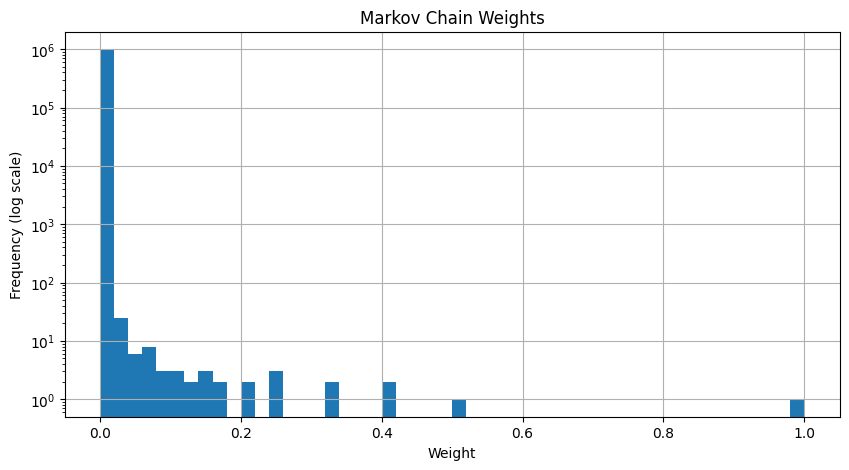

In [24]:
np.random.seed(1000)  

sampled_indices_bert = np.random.choice(vocab_size_bert, size=sample_size, replace=False)
copy_chain_bert = CHAIN_BERT[sampled_indices_bert, :][:, sampled_indices_bert]

plot_histograms(copy_chain_bert)

It shows a highly skewed distribution with a large frequency of weights close to 0, and the frequency quickly drops as the weight increases.
This indicates that in the BERT-base model's Markov chain, most transitions between states (or tokens) have a very low probability, with only a few high-probability transitions. The log scale on the y-axis suggests that the differences in frequencies are quite substantial.

<font size="5">GPT-2

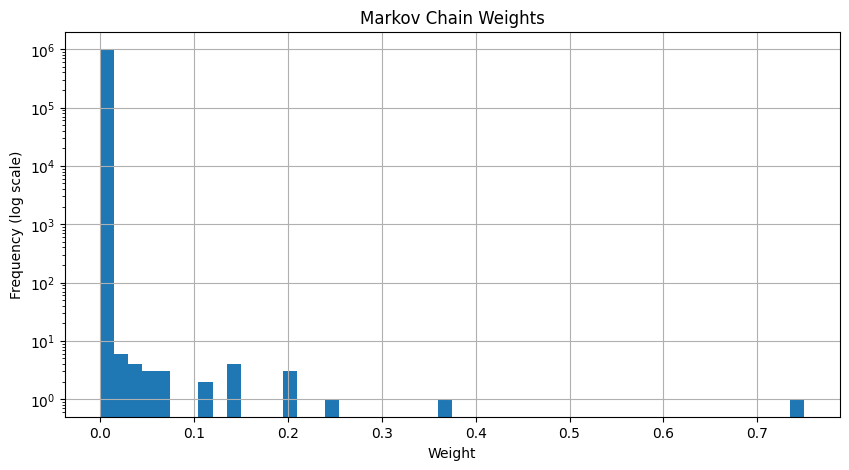

In [25]:
# Mock chain matrix with random probabilities
np.random.seed(1000)

sampled_indices_gpt2 = np.random.choice(vocab_size_gpt2, size=sample_size, replace=False)
copy_chain_gpt2 = CHAIN_GPT2[sampled_indices_gpt2, :][:, sampled_indices_gpt2]

plot_histograms(copy_chain_gpt2)
    

Similar to the BERT-base histogram, the GPT-2 histogram also shows a distribution that is heavily skewed towards the lower weights, with a rapid decline in frequency as the weight increases. The GPT-2 histogram appears to have a slightly more even distribution of weights compared to the BERT-base histogram, but still, the majority of weights are very close to 0. This pattern suggests that, like BERT, GPT-2 also has many low-probability transitions between tokens.

<font size="5">Word-Based

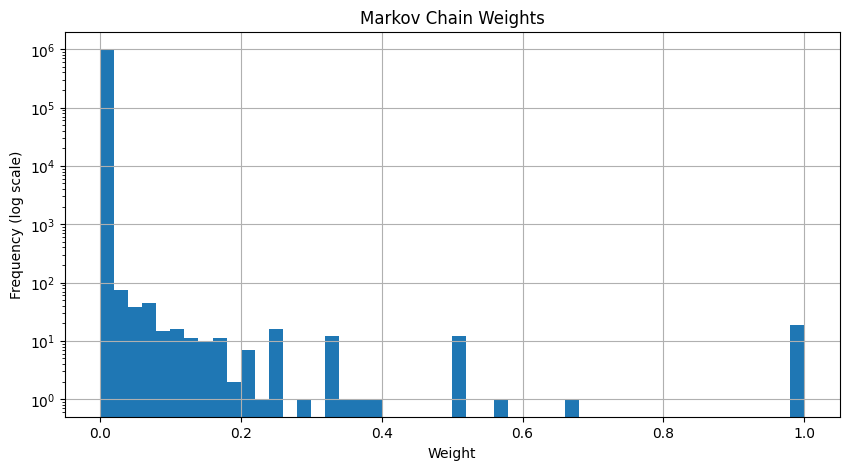

In [22]:
# Mock chain matrix with random probabilities
np.random.seed(1000)  
vocab_size = len(VOCAB_ARR)

sampled_indices = np.random.choice(vocab_size, size=sample_size, replace=False)
copy_chain = CHAIN[sampled_indices, :][:, sampled_indices]

plot_histograms(copy_chain)

The word-based approach also shows a skewed distribution but looks to have a somewhat flatter decline than the BERT-base and GPT-2 histograms. This might indicate a more uniform distribution of transition probabilities between tokens. There's a notable frequency of higher-weighted transitions compared to the BERT-base and GPT-2 histograms.

<font size="5">SVD Rank

In [17]:
def plot_sv(chain, k):
    # Take the SVD and plot the singular values
    u, s, vh = np.linalg.svd(chain, full_matrices=False)
    
    plt.figure(figsize=(10, 5))
    plt.plot(s[:k])
    plt.title('Singular Values of the Markov Chain Matrix')
    plt.xlabel('Index')
    plt.ylabel('Singular Value')
    plt.grid(True)
    plt.show()

<font size="4">BERT-Base

The rank of the matrix is: 46


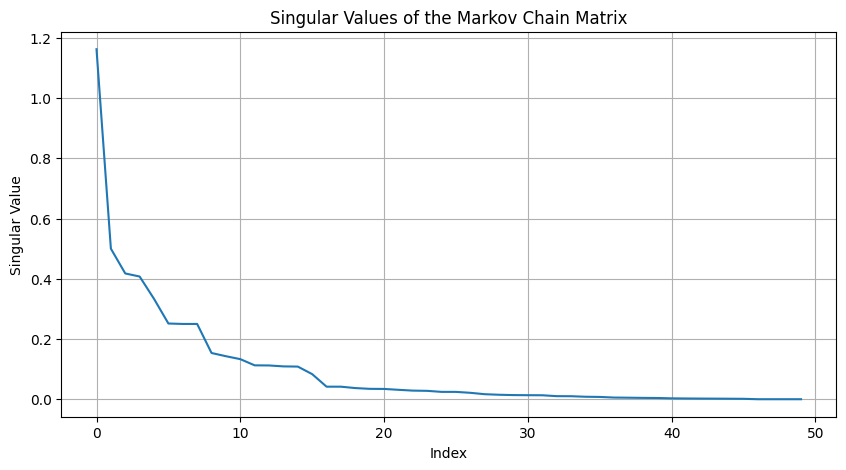

In [26]:
# Find the rank of the matrix
rank_bert = np.linalg.matrix_rank(copy_chain_bert)
print(f"The rank of the matrix is: {rank_bert}")

# Plot SV
plot_sv(copy_chain_bert,50)

The plot shows that the singular values start near 1 and decrease steadily. A few initial singular values are relatively high, indicating that there are a few dominant directions in the vector space modeled by the matrix. The rank of this matrix is 44 so it have relatively high complexity.

<font size="4">GPT-2

The rank of the matrix is: 18


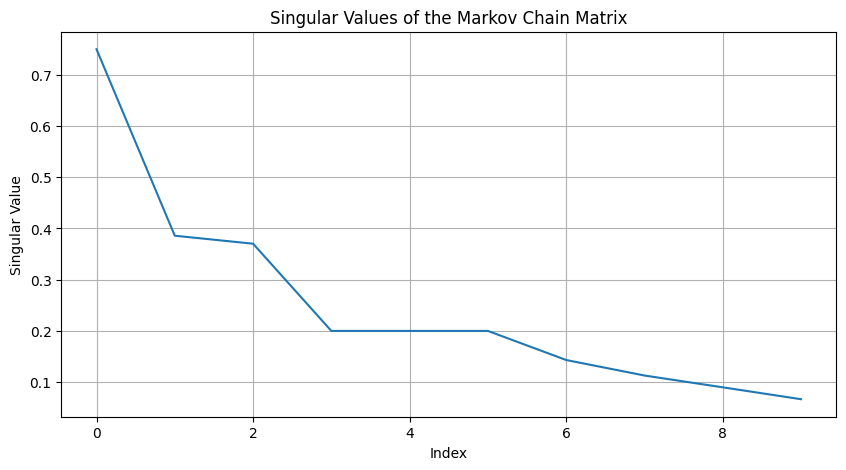

In [27]:
# Find the rank of the matrix
rank_gpt2 = np.linalg.matrix_rank(copy_chain_gpt2)
print(f"The rank of the matrix is: {rank_gpt2}")

# Plot SV
plot_sv(copy_chain_gpt2,10)


The singular values for the GPT-2 matrix also begin high and decrease, but the drop-off is more rapid compared to the BERT-base matrix. This suggests that there may be fewer dominant directions in the GPT-2 matrix's vector space, which could be interpreted as having more compact or focused data structure or relationships in the model's tokenization pattern. The rank is 21, suggesting that the GPT-2 Markov chain has fewer dimensions it works within compared to the BERT-base.

<font size="4">Word-Based

The rank of the matrix is: 85


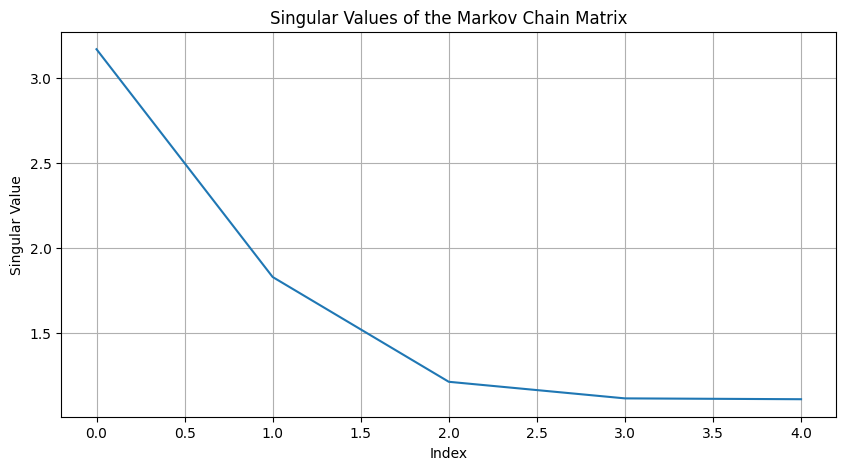

In [23]:
# Find the rank of the matrix
rank = np.linalg.matrix_rank(copy_chain)
print(f"The rank of the matrix is: {rank}")

# Plot SV
plot_sv(copy_chain,5)

The singular values here decrease sharply after the first one, indicating that there is one very dominant direction in the vector space with other directions being significantly less important. The rank is 71, which is higher than both the BERT-base and GPT-2 matrices, suggesting a higher complexity or dimensionality in the word-based model. This could be due to the fact that word-based tokenization considers each word as a separate entity, potentially leading to a more complex and less compressed representation.